Harshani Rathnayake

Project 1: Python Code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

**Part 1:**

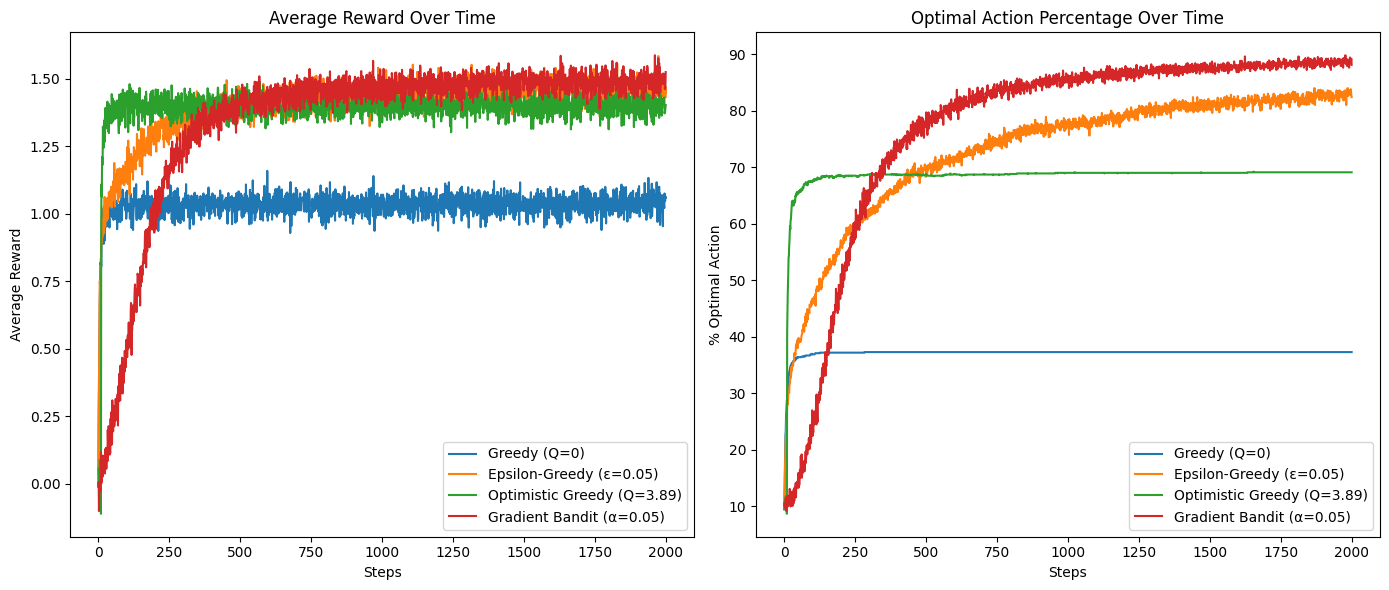

Greedy (Q=0): Final Avg Reward = 1.043, Final % Optimal = 37.30%
Epsilon-Greedy (ε=0.05): Final Avg Reward = 1.462, Final % Optimal = 82.74%
Optimistic Greedy (Q=3.89): Final Avg Reward = 1.399, Final % Optimal = 69.10%
Gradient Bandit (α=0.05): Final Avg Reward = 1.493, Final % Optimal = 88.58%


In [7]:
#Step 1: Bandit Environment
class Bandit:
    def __init__(self, k=10):
        #This initializes a k-armed bandit with true action values sampled from a normal distribution
        self.k = k  #number of arms
        self.means = np.random.normal(0, 1, k)  #true reward means for each arm
        self.optimal_action = np.argmax(self.means)  #index of the best arm (highest mean)
    def step(self, action):
        #This generates a stochastic reward for the selected action (arm)
        return np.random.normal(self.means[action], 1)  # reward is drawn from N(true_mean, 1)

def argmax_random_tie(values):
    #This returns the index of the maximum value in the array, breaking ties randomly
    max_val = np.max(values)
    candidates = np.flatnonzero(values == max_val)  #indices with max value
    return np.random.choice(candidates)


#Step 2: Action Selection Algorithms
def greedy(bandit, steps=2000):
    #Greedy strategy: always pick the current best-known action (Q)
    Q = np.zeros(bandit.k)  #estimated rewards
    N = np.zeros(bandit.k) #count of times each arm was selected
    rewards = []
    optimal_actions = []
    for t in range(steps):
        action = argmax_random_tie(Q)  #select best current action
        reward = bandit.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action] #incremental update
        rewards.append(reward)
        optimal_actions.append(int(action == bandit.optimal_action))
    return rewards, optimal_actions

def epsilon_greedy(bandit, epsilon=0.1, steps=2000):
    #Epsilon-greedy strategy: with probability epsilon, explore; otherwise exploit
    Q = np.zeros(bandit.k)
    N = np.zeros(bandit.k)
    rewards = []
    optimal_actions = []
    for t in range(steps):
        if np.random.rand() < epsilon:
            action = np.random.randint(bandit.k)  #explore
        else:
            action = argmax_random_tie(Q)  #exploit
        reward = bandit.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards.append(reward)
        optimal_actions.append(int(action == bandit.optimal_action))
    return rewards, optimal_actions

def optimistic_greedy(bandit, initial_value=5.0, steps=2000):
    #Optimistic greedy: initializes estimates with high values to encourage initial exploration
    Q = np.ones(bandit.k) * initial_value  #optimistic start
    N = np.zeros(bandit.k)
    rewards = []
    optimal_actions = []
    for t in range(steps):
        action = argmax_random_tie(Q)
        reward = bandit.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards.append(reward)
        optimal_actions.append(int(action == bandit.optimal_action))
    return rewards, optimal_actions

def gradient_bandit(bandit, alpha=0.1, steps=2000):
    #Gradient bandit algorithm using preference values and softmax action selection
    H = np.zeros(bandit.k)  #preferences
    avg_reward = 0
    rewards = []
    optimal_actions = []
    for t in range(steps):
        probs = np.exp(H) / np.sum(np.exp(H))  #softmax over preferences
        action = np.random.choice(bandit.k, p=probs) #pick action based on probabilities
        reward = bandit.step(action)
        avg_reward += (reward - avg_reward) / (t + 1)  #update average reward
        #Update preferences:
        for a in range(bandit.k):
            H[a] += alpha * ((1 if a == action else 0) - probs[a]) * (reward - avg_reward)
        rewards.append(reward)
        optimal_actions.append(int(action == bandit.optimal_action))
    return rewards, optimal_actions

#Step 3: Run a Simulation
def run_simulation(algo_func, runs=1000, **kwargs):
    #Below runs a bandit algorithm multiple times and average the results
    steps = kwargs.get('steps', 2000)
    avg_rewards = np.zeros(steps)
    optimal_action_counts = np.zeros(steps)
    for _ in range(runs):
        bandit = Bandit()
        rewards, optimal_actions = algo_func(bandit, **kwargs)
        avg_rewards += rewards
        optimal_action_counts += optimal_actions
    avg_rewards /= runs
    optimal_action_counts = (optimal_action_counts / runs) * 100  #convert to percentage
    return avg_rewards, optimal_action_counts

#Step 4: Tune the Initial Value for Optimistic Greedy
optimistic_values = []
for _ in range(20):
    b = Bandit()
    max_mean = max(b.means)
    # Calculate a high quantile value from a normal distribution centered on max_mean
    percentile = np.percentile(np.random.normal(loc=max_mean, scale=1, size=100000), 99.5)
    optimistic_values.append(percentile)
#Below is the final average optimistic Q-value
optimistic_value = np.mean(optimistic_values)


#Step 5: Tune Epsilon
epsilons = [0.01, 0.05, 0.1, 0.2]
epsilon_results = {}
#Trying different epsilons and record final average rewards
for eps in epsilons:
    rewards, _ = run_simulation(epsilon_greedy, epsilon=eps, runs=200, steps=500)
    epsilon_results[eps] = np.mean(rewards[-100:])  #average of last 100 steps
#Choose epsilon that gave highest average reward
best_eps = max(epsilon_results, key=epsilon_results.get)


#Step 6: Tune Alpha
alphas = [0.01, 0.05, 0.1, 0.4]
alpha_results = {}
#Tring different alphas and record final average rewards
for a in alphas:
    rewards, _ = run_simulation(gradient_bandit, alpha=a, runs=200, steps=500)
    alpha_results[a] = np.mean(rewards[-100:])

#Choose the best alpha value
best_alpha = max(alpha_results, key=alpha_results.get)

#Step 7: Final Run of the Algorithms
results = {
    "Greedy (Q=0)": run_simulation(greedy),
    f"Epsilon-Greedy (ε={best_eps})": run_simulation(epsilon_greedy, epsilon=best_eps),
    f"Optimistic Greedy (Q={optimistic_value:.2f})": run_simulation(optimistic_greedy, initial_value=optimistic_value),
    f"Gradient Bandit (α={best_alpha})": run_simulation(gradient_bandit, alpha=best_alpha)
}


#Step 8: Ploting the Results
def plot_results(results):
    plt.figure(figsize=(14, 6))
    #Plot average reward:
    plt.subplot(1, 2, 1)
    for label, (rewards, _) in results.items():
        plt.plot(rewards, label=label)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Over Time")
    plt.legend()

    #Plot optimal action percentage:
    plt.subplot(1, 2, 2)
    for label, (_, optimal_actions) in results.items():
        plt.plot(optimal_actions, label=label)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title("Optimal Action Percentage Over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()
#Calling the plot function
plot_results(results)

#Step 9: Final Summary Output
#Below prints the final performance for each algorithm
for label, (rewards, optimal) in results.items():
    final_avg_reward = np.mean(rewards[-100:]) #last 100 steps
    final_opt_action = np.mean(optimal[-100:])  #last 100 steps
    print(f"{label}: Final Avg Reward = {final_avg_reward:.3f}, Final % Optimal = {final_opt_action:.2f}%")

**Part 2:**

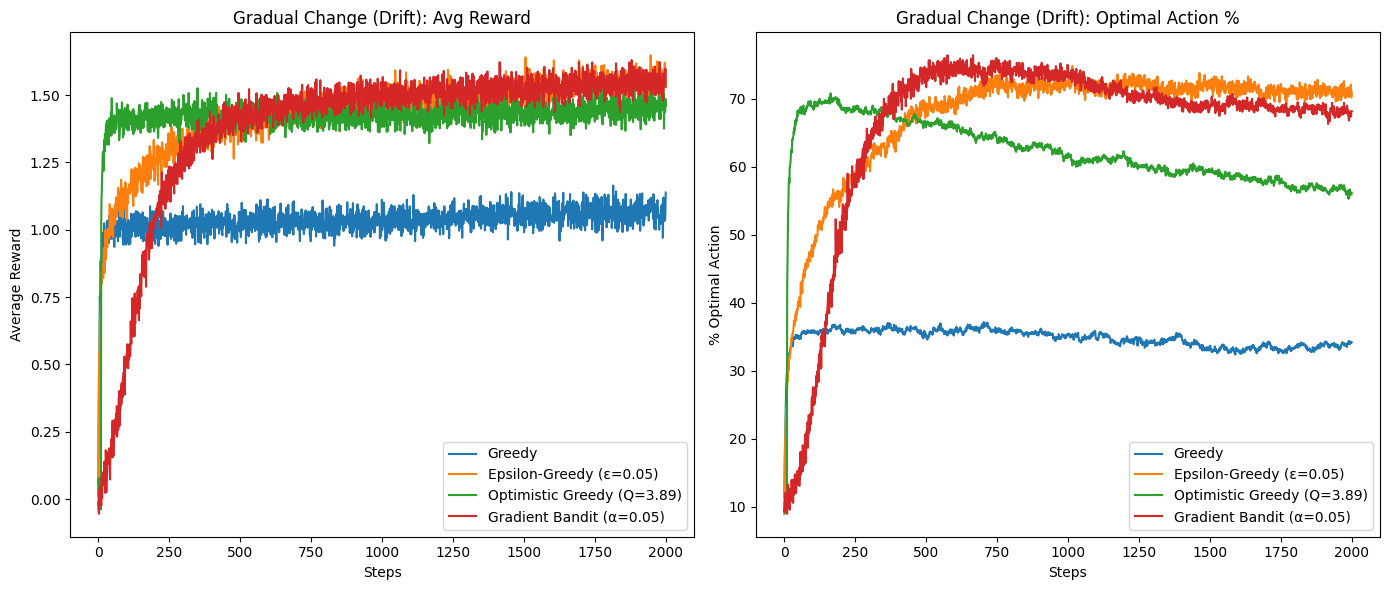

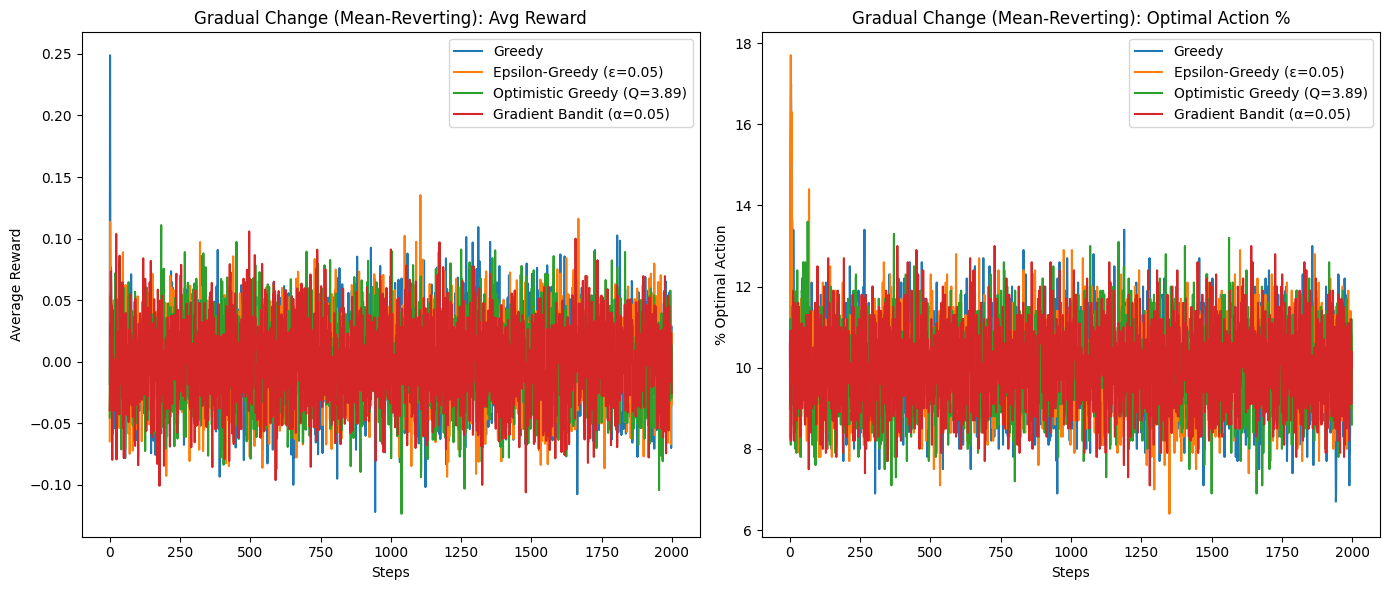

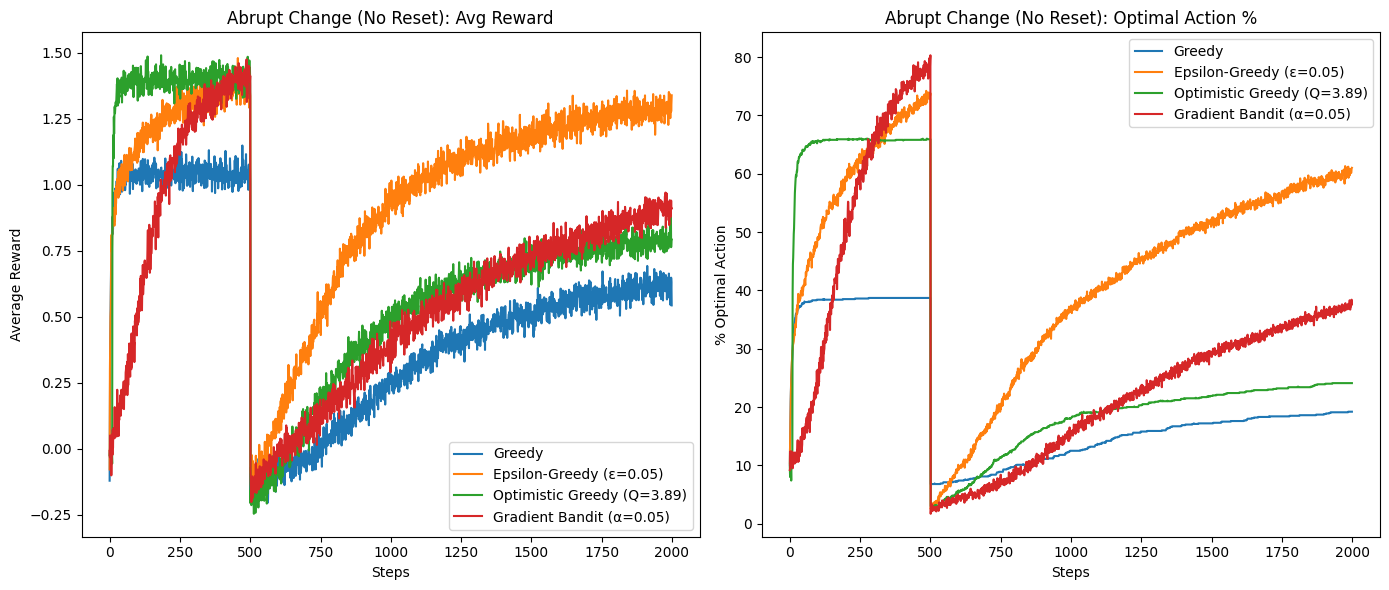

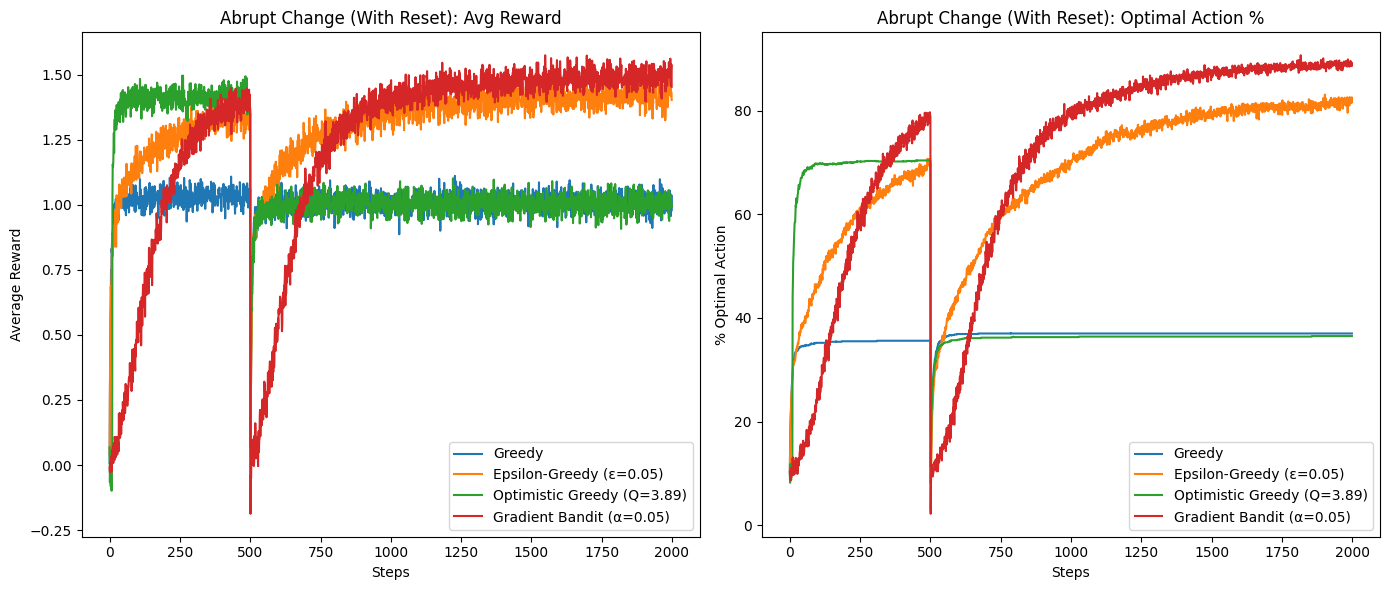


 Final Summary for Gradual Change (Drift) 
Greedy: Final Avg Reward = 1.138, Final % Optimal Action = 34.20%
Epsilon-Greedy (ε=0.05): Final Avg Reward = 1.563, Final % Optimal Action = 71.10%
Optimistic Greedy (Q=3.89): Final Avg Reward = 1.460, Final % Optimal Action = 56.20%
Gradient Bandit (α=0.05): Final Avg Reward = 1.531, Final % Optimal Action = 68.20%

 Final Summary for Gradual Change (Mean-Reverting) 
Greedy: Final Avg Reward = 0.028, Final % Optimal Action = 9.60%
Epsilon-Greedy (ε=0.05): Final Avg Reward = -0.035, Final % Optimal Action = 9.90%
Optimistic Greedy (Q=3.89): Final Avg Reward = -0.029, Final % Optimal Action = 8.60%
Gradient Bandit (α=0.05): Final Avg Reward = -0.026, Final % Optimal Action = 10.00%

 Final Summary for Abrupt Change (No Reset) 
Greedy: Final Avg Reward = 0.543, Final % Optimal Action = 19.20%
Epsilon-Greedy (ε=0.05): Final Avg Reward = 1.339, Final % Optimal Action = 61.00%
Optimistic Greedy (Q=3.89): Final Avg Reward = 0.793, Final % Optimal 

In [9]:
#Non-Stationary Bandit Class:
class NonStationaryBandit:
    def __init__(self, k=10, change_type=None, seed=None, permutation=None, noise_stream=None):
        self.k = k  #number of arms (actions)
        rng = np.random.default_rng(seed)  #reproducible random generator with optional seed
        self.means = rng.normal(0, 1, k)  #initialize mean reward for each arm from N(0,1)
        self.original_means = self.means.copy()  #backup of original means (for comparison or reset)
        self.optimal_action = np.argmax(self.means)  #initially optimal action (arm with highest mean)
        self.change_type = change_type  #type of environment change ('drift', 'abrupt', etc)
        self.permutation = permutation  #used in abrupt change (permutes the arm means)
        self.noise_stream = noise_stream  #stream of noise vectors for gradual changes

    def step(self, t, action):
        #Apply changes to the means based on the type of environment
        if self.change_type == 'drift':
            #Gradually drift the means with small noise
            if t > 0:
                self.means += self.noise_stream[t]
        elif self.change_type == 'mean_reverting':
            #Move means closer to zero with some noise
            if t > 0:
                self.means = 0.5 * self.means + self.noise_stream[t]
        elif self.change_type == 'abrupt' and t == 501:
            #At time t=501, apply abrupt permutation of means
            self.means = self.means[self.permutation]
        #Update optimal action after changes
        self.optimal_action = np.argmax(self.means)
        #Return a sample reward from N(mean[action], 1)
        return np.random.normal(self.means[action], 1)

#Runner for Non-Stationary Bandit Algorithms:
def run_nonstationary(algo_func, change_type, reset=False, **kwargs):
    runs = kwargs.get('runs', 1000)
    steps = kwargs.get('steps', 2000)
    avg_rewards = np.zeros(steps)  #to accumulate average rewards across all runs
    optimal_action_counts = np.zeros(steps)  #to accumulate % optimal actions
    seeds = np.arange(runs)
    #Create a fixed permutation for abrupt changes
    permutation = np.random.permutation(10)
    #Create noise streams for each run - used in drift or mean-reverting
    noise_streams = [np.random.normal(0, 0.012, (steps, 10)) for _ in range(runs)]
    #Run simulation over multiple independent seeds
    for seed in seeds:
        bandit = NonStationaryBandit(
            change_type=change_type,
            seed=seed,
            permutation=permutation,
            noise_stream=noise_streams[seed]
        )
        #Initialization of parameters
        Q = np.zeros(bandit.k)  #estimated value of each arm
        N = np.zeros(bandit.k) #number of times each arm was selected
        H = np.zeros(bandit.k) #preference values for gradient bandit
        avg_reward = 0  #running average of reward for gradient bandit
        #Extract tuning hyperparameters
        alpha = kwargs.get('alpha', 0.1)
        epsilon = kwargs.get('epsilon', 0.1)
        init_val = kwargs.get('initial_value', 0)
        #For optimistic method, set high initial Q values
        if algo_func.__name__ == "optimistic_greedy":
            Q = np.ones(bandit.k) * init_val
        rewards = []
        optimal_actions = []
        for t in range(steps):
            #Action selection based on algorithm type
            if algo_func.__name__ == "epsilon_greedy":
                if np.random.rand() < epsilon:
                    action = np.random.randint(bandit.k)
                else:
                    action = argmax_random_tie(Q)
            elif algo_func.__name__ in ["greedy", "optimistic_greedy"]:
                action = argmax_random_tie(Q)
            elif algo_func.__name__ == "gradient_bandit":
                probs = np.exp(H) / np.sum(np.exp(H))
                action = np.random.choice(bandit.k, p=probs)
            #Get reward from bandit
            reward = bandit.step(t, action)
            #Optional reset at time of abrupt change
            if reset and t == 501:
                Q = np.zeros(bandit.k)
                N = np.zeros(bandit.k)
                H = np.zeros(bandit.k)
                avg_reward = 0
            #Update estimates or preferences
            if algo_func.__name__ in ["greedy", "epsilon_greedy", "optimistic_greedy"]:
                N[action] += 1
                Q[action] += (reward - Q[action]) / N[action]
            elif algo_func.__name__ == "gradient_bandit":
                avg_reward += (reward - avg_reward) / (t + 1)
                for a in range(bandit.k):
                    H[a] += alpha * ((1 if a == action else 0) - probs[a]) * (reward - avg_reward)
            #Record metrics
            rewards.append(reward)
            optimal_actions.append(int(action == bandit.optimal_action))
        avg_rewards += rewards
        optimal_action_counts += optimal_actions
    #Average metrics across runs
    avg_rewards /= runs
    optimal_action_counts = (optimal_action_counts / runs) * 100
    return avg_rewards, optimal_action_counts


#Plotting Function for Non-Stationary Experiments:
def plot_nonstationary(results, title):
    plt.figure(figsize=(14, 6))
    #Plot: Average reward over Time
    plt.subplot(1, 2, 1)
    for label, (rewards, _) in results.items():
        plt.plot(rewards, label=label)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title(f"{title}: Avg Reward")
    plt.legend()
    #Plot: Optimal action percentage over Time
    plt.subplot(1, 2, 2)
    for label, (_, optimal_actions) in results.items():
        plt.plot(optimal_actions, label=label)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title(f"{title}: Optimal Action %")
    plt.legend()
    plt.tight_layout()
    plt.show()

#Run Experiments for Different Change Types:
#Gradual Drift Change (non-stationary rewards increase/decrease slowly):
drift_results = {
    "Greedy": run_nonstationary(greedy, change_type='drift'),
    f"Epsilon-Greedy (ε={best_eps})": run_nonstationary(epsilon_greedy, change_type='drift', epsilon=best_eps),
    f"Optimistic Greedy (Q={optimistic_value:.2f})": run_nonstationary(optimistic_greedy, change_type='drift', initial_value=optimistic_value),
    f"Gradient Bandit (α={best_alpha})": run_nonstationary(gradient_bandit, change_type='drift', alpha=best_alpha)
}
plot_nonstationary(drift_results, "Gradual Change (Drift)")

#Gradual Mean-Reverting Change (rewards decay towards zero):
reverting_results = {
    "Greedy": run_nonstationary(greedy, change_type='mean_reverting'),
    f"Epsilon-Greedy (ε={best_eps})": run_nonstationary(epsilon_greedy, change_type='mean_reverting', epsilon=best_eps),
    f"Optimistic Greedy (Q={optimistic_value:.2f})": run_nonstationary(optimistic_greedy, change_type='mean_reverting', initial_value=optimistic_value),
    f"Gradient Bandit (α={best_alpha})": run_nonstationary(gradient_bandit, change_type='mean_reverting', alpha=best_alpha)
}
plot_nonstationary(reverting_results, "Gradual Change (Mean-Reverting)")

#Abrupt Change WITHOUT Reset (agent continues using old Q/H):
abrupt_norestart_results = {
    "Greedy": run_nonstationary(greedy, change_type='abrupt', reset=False),
    f"Epsilon-Greedy (ε={best_eps})": run_nonstationary(epsilon_greedy, change_type='abrupt', epsilon=best_eps, reset=False),
    f"Optimistic Greedy (Q={optimistic_value:.2f})": run_nonstationary(optimistic_greedy, change_type='abrupt', initial_value=optimistic_value, reset=False),
    f"Gradient Bandit (α={best_alpha})": run_nonstationary(gradient_bandit, change_type='abrupt', alpha=best_alpha, reset=False)
}
plot_nonstationary(abrupt_norestart_results, "Abrupt Change (No Reset)")

#Abrupt Change WITH Reset (agent resets internal estimates at t=501):
abrupt_reset_results = {
    "Greedy": run_nonstationary(greedy, change_type='abrupt', reset=True),
    f"Epsilon-Greedy (ε={best_eps})": run_nonstationary(epsilon_greedy, change_type='abrupt', epsilon=best_eps, reset=True),
    f"Optimistic Greedy (Q={optimistic_value:.2f})": run_nonstationary(optimistic_greedy, change_type='abrupt', initial_value=optimistic_value, reset=True),
    f"Gradient Bandit (α={best_alpha})": run_nonstationary(gradient_bandit, change_type='abrupt', alpha=best_alpha, reset=True)
}
plot_nonstationary(abrupt_reset_results, "Abrupt Change (With Reset)")

#Final Summary of the values:
def print_final_summary(results, title):
    print(f"\n Final Summary for {title} ")
    for label, (avg_rewards, optimal_actions) in results.items():
        final_avg_reward = avg_rewards[-1]
        final_optimal_pct = optimal_actions[-1]
        print(f"{label}: Final Avg Reward = {final_avg_reward:.3f}, Final % Optimal Action = {final_optimal_pct:.2f}%")
    print("="*40)
#Print summary of each experiment:
print_final_summary(drift_results, "Gradual Change (Drift)")
print_final_summary(reverting_results, "Gradual Change (Mean-Reverting)")
print_final_summary(abrupt_norestart_results, "Abrupt Change (No Reset)")
print_final_summary(abrupt_reset_results, "Abrupt Change (With Reset)")